
# Data Engineering demo

Aiming to serve as reference on future needs from Executive, Analytics and Design teams,

this demo shows OSAA NGO data extraction, transformation, and data pipelines:


- written in 3-hours to show how we improve processes with automation, optimize delivery and creation / maintenance of data catalogues (e.g. by Country & Map).
- This extracted data is available at UN Web and this https://github.com/infchg/maps bring it ready for data scientists and analysts ( in jupyter R python demos).
- This system follows ITIL Change to allow governance, protection, privacy, and security. (For instance,  see history of this October 2021 public changes at github.com/infchg/  )
- To minimize harmful biases, this code is not filtering by words and -while started assuming addresses were in english- it is open to process different languages later.
- next, For objective measurement of data validity, the NGO's url reachability can be checked 

### Thanks

This data engineering costed $0 by accessing scalable servers from large providers we thank here:
- MyBinder on Google C servers https://gke.mybinder.org/v2/gh/infchg/maps/main?urlpath=tree
- Jupyter.org on Cloudflare servers https://nbviewer.jupyter.org/github/infchg/maps/blob/master/NGO-OSAA-more.ipynb
- Heroku on AWS servers https://dasn.herokuapp.com/covid19 & stats 
- Pantheon MariaDB on Google C servers 	mysql -h dbserver.dev.a139e97b-8103-4993-b299-97f2051e5529.drush.in  
- architecture and integration by C. J. using python, shell, spark,  Oct-2021

thanks to resources by http://Jupyter.org http://MyBinder.org http://Heroku.com and above


## Demo 1. Retrieving data from web sources into python

Instead of a simple query of database, let us make an extraction of public data from UN Web:

First, consider the impact of data extraction on the database and discuss with data and system owners. Both Webs and DBs can limit data queries, this example will query a few NGOs only.

Let us start exploring the NGOs in Africa, by querying the database interface (REST API) in groups of 25 NGOs:


In [1]:
!curl 'https://esango.un.org/civilsociety/withOutLogin.do?method=getOrgsByRegionsCode&orgByRegionCode=1&orgByRegionName=Africa&sessionCheck=false&ngoFlag=' -o firstList.htm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50583    0 50583    0     0  82115      0 --:--:-- --:--:-- --:--:-- 81982


In [2]:
!grep  Code=.*\<  firstList.htm  -o| sed 's/">/\t/;s/<//;s/\&quot;//g;s/Code=//' | tee list.tsv | head #show a few

625018	Coup de Pousse Cha&icirc;ne de l&rsquo;Espoir Nord-Sud ( C.D.P-C.E.N.S)
659386	Fondation - Afrique d&eacute;veloppement international (F.A.D.I.)
602801	Tort for Torture Victims Centre (TT-VC)
611685	1GOAL: Global Campaign for Education
617293	31st December Women's Movement
619874	3D Revolving Fund Initiative
635434	A3 Foundation nig
628005	AAFCOOP
668907	Aalem for Orphan and Vulnerable Children,Inc.
674137	AATASSIMO


In [3]:
!pip install pandas >& /dev/null && echo OK || echo or-please-check-installs # seaborn 

OK


In [4]:
import pandas as pd
df = pd.read_csv('list.tsv', sep='\t', header=None)
display(df.tail())

,0,1
20,631376,Ability Focus
21,674049,Abnaa Al Mahrousa Foundation for Development a...
22,603860,ABRAR ORGANIZATION FOR CARE OF WAR DISABLE AND...
23,618966,Acacia Development Society
24,610319,ACADEMIC HEALTH AND AGRICULTURAL DEVELOPMENT I...



## 2. Automate visits to each NGO web link. Iterate searching for country ...

Now, Crawling, we  follow each of the web links, and extract country from each of the NGOs listed :

In [5]:
!grep -oE '"showPr[^"]+' firstList.htm | sed -E 's|"| curl "https://esango.un.org/civilsociety/|;s|=([0-9]+)|=\1" -o \1.htm |'  > many-curls.sh
!head -2 many-curls.sh   # Automates One web check per NGOs  -- No needed when you can access the Database

 curl "https://esango.un.org/civilsociety/showProfileDetail.do?method=showProfileDetails&profileCode=625018" -o 625018.htm 
 curl "https://esango.un.org/civilsociety/showProfileDetail.do?method=showProfileDetails&profileCode=659386" -o 659386.htm 


In [6]:
! bash ./many-curls.sh >& logs  # run de data downloads and check the number of files
!  echo Found $(ls *htm |wc -l) files , where it is fine with +25 for the demo

Found 26 files , where it is fine with +25 for the demo


In [7]:
!grep -iB4 phone *htm | grep -E htm-\\s+\\w  | sed s/.htm-/,/ | tee cc.csv | head  # Extract Country from each NGO

In [8]:
df_cc = pd.read_csv('cc.csv' , header=None)  # Country Codes CC, actually Country Names extracted from Webs
display(df_cc.sort_values(by=[df_cc.columns[-1]]).head())  # Sorted by Country Name, i.e. last column, -1

,0,1
12,628058,Benin
1,602801,Cameroon
16,629078,Cameroon
11,628005,Cameroon
23,674049,Egypt


## 3. Scalable tools to automate formating and building reports

We can reformat data to PDF HTML TEXT automatically, see how  this web data is shown as plain text:

In [9]:
! pandoc  628005.htm  -f html -t plain | grep -A4 address      

  Headquarters address                 

  Address:                            B.P. 4439,Yaounde,Cameroon
                                      Cameroon



### including Visual Checks  

just a simple demo on how to verify data and display 

<AxesSubplot:title={'center':'Simple visual check of Queried NGS (x) and their IDs (y)'}>

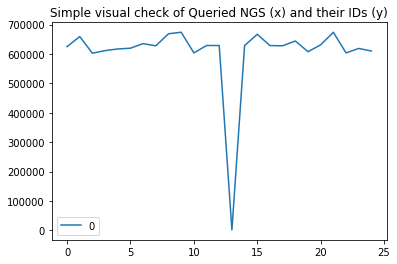

In [16]:
 %matplotlib inline
df.plot(title="Simple visual check of Queried NGS (x) and their IDs (y)")  #xticks=df.columns[1],yticks=df.columns[0])

## Joining Data Tables, and Grouping by Country

Data columns using labels to simplify usage. We show a SQL Inner Join.

In [29]:
df.columns = ['id', 'ngo']
df_cc.columns = ['id', 'country']
df_both = pd.merge(df, df_cc, on = "id", how = "inner")
df_both.head()


,id,ngo,country
0,625018,Coup de Pousse Cha&icirc;ne de l&rsquo;Espoir ...,Togo
1,659386,Fondation - Afrique d&eacute;veloppement inter...,Togo
2,602801,Tort for Torture Victims Centre (TT-VC),Cameroon
3,611685,1GOAL: Global Campaign for Education,South Africa
4,617293,31st December Women's Movement,Ghana


In [39]:
print("Grouping by Country in this small selection of 25 NGOs")
stats=pd.DataFrame( df_both["country"].value_counts() )
stats.transpose()

Grouping by Country in this small selection of 25 NGOs


,Ghana,Nigeria,Cameroon,Togo,South Africa,Uganda,Liberia,Tunisia,Senegal,Sierra Leone,Ethiopia,Benin,Egypt,Sudan,United Republic of Tanzania,Kenya
country,4,4,3,2,1,1,1,1,1,1,1,1,1,1,1,1


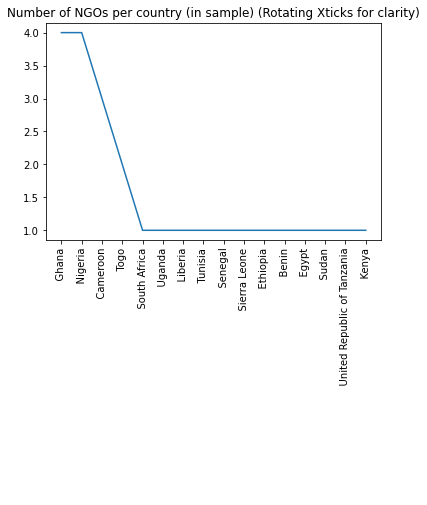

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot( stats )
plt.xticks(rotation = 90)
plt.title('Number of NGOs per country (in sample) (Rotating Xticks for clarity)')
plt.show()